<a href="https://colab.research.google.com/github/UOS-COMP6252/public/blob/main/lecture3/backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Backpropagation practical exercise
Learning outcomes: you will be able to
1. Describe how the backward graph is implemented in PyTorch using the ```grad_fn.next_functions```
1. Explain how PyTorch uses computational graphs to implement backpropagation   
1. Apply PyTorch ```grad_fn``` to compute the gradient of any expression


## Backpropagation
 - We saw that PyTorch can compute the gradient to any function. 
 - To accomplish this, PyTorch uses three concepts:
 
 1. Computational graph
 1. "Database" of derivatives to **primitive** functions
 1. Chain rule

- Consider the following computations:
$$
\begin{align*}
a&=2\\
b&=4\\
c&=a+b\\
d&=\log(a)*\log(b)\\
e&=c*d
\end{align*}
$$
 

 Where $\log(x)$ is the log base two. 
 

- For every **primitive** operation, PyTorch "knows" its derivative. 
- For example, PyTorch has the following rules stored and can look them up when needed.

1. $\frac{\partial\log(x)}{\partial x}=\frac{1}{x*\ln(2)}$
1. $\frac{\partial (x*y)}{\partial x}=y$
1. $\frac{\partial (x*y)}{\partial y}=x$
1. $\frac{\partial (x+y)}{\partial x}=1$
1. $\frac{\partial (x+y)}{\partial y}=1$

- The PyTorch code corresponding to the example is shown below. Note:
1. For each **leaf** tensor ```X```, the gradient is stored in ```X.grad```
1. The values for **non-leaf** node ```Y``` is **not** saved, unless ```Y.retain_grad()``` is called

In [ ]:
import torch
a=torch.tensor(2.,requires_grad=True)
b=torch.tensor(4.,requires_grad=True)
c=a+b # c=6
d=torch.log2(a)*torch.log2(b)# d=2
#d.retain_grad()
e=c*d
e.backward(retain_graph=True)
#e.backward()
print(a.grad,b.grad)

tensor(10.6562) tensor(4.1640)


- We will be going through the computation step by step to obtain the same result
- How does ```backward``` work? 
- Recursively calls the ```.grad_fn``` of each node in the graph
- We use ```.no_grad()``` so that PyTorch does not build a CG  for the computations below

- Note that the code below will give an **error** if we use ```e.backward()``` instead of  ```e.backward(retain_graph=True)```because the graph is **destroyed** after the call to ```.backward()```

In [11]:
with torch.no_grad():
    dedc,dedd=e.grad_fn(torch.tensor(1.))
    print("gradient of e wrt to c={}, wrt to d={}".format(dedc,dedd))
    

gradient of e wrt to c=2.0, wrt to d=6.0


In [23]:
with torch.no_grad():
    print("c\'s contribution to grad of e wrt to a and b: {}".format(c.grad_fn(dedc)))
    print("What does this output {} correspond to?".format(d.grad_fn(dedd)))


c's contribution to grad of e wrt to a and b: (tensor(2.), tensor(2.))
What does this output (tensor(12.), tensor(6.)) correspond to?


$\frac{\partial d}{\partial \log a}=\log b=2$ and $\frac{\partial d}{\partial \log b}=\log a=1$
Multiply by $\frac{\partial e}{\partial d}=6$ to get 12 and 6

- Recall that the results for ```c.grad_fn``` are added to ```a``` and ```b```
- but the results for ```d.grad_fn``` are fed to **unnamed** intermediate nodes
- How does one proceed? How does PyTorch keep track?
- Actually PyTorch keeps track of the next ```grad_fn``` to call using ```next_functions``` object

In [13]:
print(d.grad_fn.next_functions)

((<Log2Backward0 object at 0x7fe8a2ddd4b0>, 0), (<Log2Backward0 object at 0x7fe8a2ddd720>, 0))


- it is a tuple of pairs of the form (function,index)
- We can almost always ignore the index. For the vast majority of operations there is only one value 0
- Also, since most operations are binary the tuple is usually a pair
- In summary, for most operations that we encounter ```.next_functions``` returns a pair of pairs where the idex in each pair can be ignored

In [14]:
with torch.no_grad():
    #the gradients are accumulated, we need to reset
    a.grad,b.grad=None,None
    # The "root" of the graph always has gradient of 1
    dedc,dedd=e.grad_fn(torch.tensor(1.))
    print("gradient of e wrt to c is={}, wrt to d={}".format(dedc,dedd))
    #gradient functions of C and D
    CgradFn=e.grad_fn.next_functions[0][0]
    DgradFn=e.grad_fn.next_functions[1][0]
    # apply to the last values
    deda,dedb=CgradFn(dedc)
    dedloga,dedlogb=DgradFn(dedd)
  


gradient of e wrt to c is=2.0, wrt to d=6.0


In [15]:
with torch.no_grad():
      
    # the "C" branch ends and accumulates in .grad
    accA1=CgradFn.next_functions[0][0]
    accB1=CgradFn.next_functions[1][0]
    accA1(deda)
    accB1(dedb)
    print("contribution of c branch to grad of a={}, to grad of b={}".format(a.grad,b.grad))
    # the "D" branch has unamed nodes, loga and logb
    LogAgradFn=DgradFn.next_functions[0][0]
    LogBgradFn=DgradFn.next_functions[1][0]

contribution of c branch to grad of a=2.0, to grad of b=2.0


In [16]:
with torch.no_grad():
    #apply to the last values
    deda=LogAgradFn(dedloga)
    dedb=LogBgradFn(dedlogb)
    # the "D" branch ends and accumulates in .grad
    accA=LogAgradFn.next_functions[0][0]
    accA(deda)
    accB=LogBgradFn.next_functions[0][0]
    accB(dedb)
    print(a.grad,b.grad)


tensor(10.6562) tensor(4.1640)


Rather than perform all the above operations manually, we can write a recursive function to go over all the nodes in the graph and computes the grads.

In [17]:
def preorder(grad_fn,input,debug=False):
    vals=grad_fn(input)
    if debug:
        print(grad_fn,input)
    if isinstance(vals,tuple):
        for (f,idx),val in zip(grad_fn.next_functions,vals):
            preorder(f,val,debug)
    else:
        # in this example the "log(a)" and "log(b)" return a single output
        # see slides page 14
        if debug:
            print(f"single return {grad_fn.next_functions[0][0]}")
        preorder(grad_fn.next_functions[0][0],vals,debug)

In [18]:
with torch.no_grad():
    a.grad,b.grad=None,None
    preorder(e.grad_fn,torch.tensor(1.))

In [19]:
print(a.grad,b.grad)

tensor(10.6562) tensor(4.1640)


In [20]:
with torch.no_grad():
    a.grad,b.grad=None,None
    preorder(e.grad_fn,torch.tensor(1.),debug=True)

<MulBackward0 object at 0x7fe8a2ddc3d0> tensor(1.)
<AddBackward0 object at 0x7fe8a2d7d6c0> tensor(2.)
<AccumulateGrad object at 0x7fe8a2d7d510> tensor(2.)
<AccumulateGrad object at 0x7fe8a2ddd840> tensor(2.)
<MulBackward0 object at 0x7fe8a2d7df60> tensor(6.)
<Log2Backward0 object at 0x7fe8a2d3e740> tensor(12.)
single return <AccumulateGrad object at 0x7fe8a2d7d510>
<AccumulateGrad object at 0x7fe8a2d7d510> tensor(8.6562)
<Log2Backward0 object at 0x7fe8a2d3ec80> tensor(6.)
single return <AccumulateGrad object at 0x7fe8a2ddd840>
<AccumulateGrad object at 0x7fe8a2ddd840> tensor(2.1640)


- In fact this is exactly how the ```torchviz``` package works (with more bells and whistles)

In [21]:
try:
    import torchviz
except ModuleNotFoundError:
    %pip install torchviz
    import torchviz


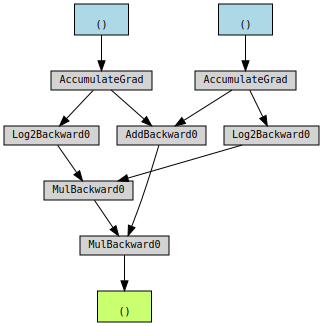

In [22]:
a=torch.tensor(2.,requires_grad=True)
b=torch.tensor(4.,requires_grad=True)
c=a+b
d=torch.log2(a)*torch.log2(b)
e=c*d
torchviz.make_dot(e)